In [39]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd

In [40]:
spark = SparkSession.builder.appName("Python Spark DataFrames basic example").config("spark.some.config.option", "some-value").getOrCreate()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15517 entries, 0 to 15516
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         15517 non-null  object 
 1   Track Name          15517 non-null  object 
 2   Popularity          15123 non-null  float64
 3   danceability        15517 non-null  float64
 4   energy              15517 non-null  float64
 5   key                 13774 non-null  float64
 6   loudness            15517 non-null  float64
 7   mode                15517 non-null  int64  
 8   speechiness         15517 non-null  float64
 9   acousticness        15517 non-null  float64
 10  instrumentalness    11930 non-null  float64
 11  liveness            15517 non-null  float64
 12  valence             15517 non-null  float64
 13  tempo               15517 non-null  float64
 14  duration_in min/ms  15517 non-null  float64
 15  time_signature      15517 non-null  int64  
 16  Genr

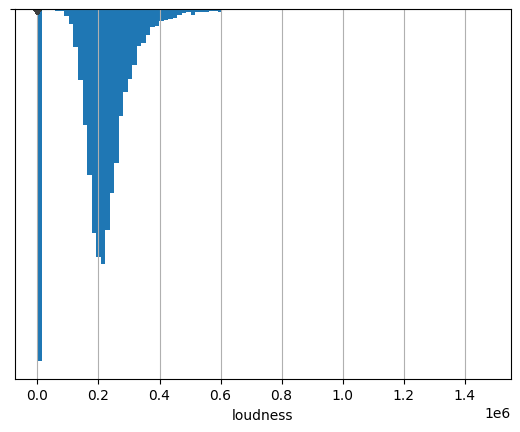

In [41]:
df = pd.read_csv(r'./music_streaming.csv')
df.head()

# get some basic info about the data
df.info()

# 1. remove duplicates (Artist Name + Track Name)
df = df.drop_duplicates(subset=['Track Name'])
df.info()

# 2. missing values in each column
df.isnull().sum()

df = df.dropna(subset=['Popularity'])
df['Popularity'].isnull().sum()


df = df.drop(columns=['key'])
df.head()

df['instrumentalness'] = df.groupby('Artist Name')['instrumentalness'].transform(lambda x: x.fillna(x.mean()))
df['instrumentalness'].isnull().sum()

# impute instrumentalness with the mean of the instrumentalness of all songs
df['instrumentalness'] = df['instrumentalness'].fillna(df['instrumentalness'].mean())
df['instrumentalness'].isnull().sum()

# plot the boxplot of loudness
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(x=df['loudness'])

Q1 = df['loudness'].quantile(0.25)
Q3 = df['loudness'].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df['loudness'] < (Q1 - 1.5 * IQR)) |(df['loudness'] > (Q3 + 1.5 * IQR)))]
sns.boxplot(x=df['loudness'])

# plot histogram of (duration_in min/ms)
df['duration_in min/ms'].hist(bins=100)

df[df['duration_in min/ms'] < 1000]['duration_in min/ms'].sort_values(ascending=False)

# maximum song length in minutes is 29.8 
# `duration_in min/ms` > 1000 then divide the value by 60000 to convert it to minutes
# we are sure that the all the values > 29.8 are in milliseconds

df['duration_in min/ms'] = df['duration_in min/ms'].apply(lambda x: x/60000 if x > 1000 else x)

In [42]:
sdf = spark.createDataFrame(df) 
sdf.printSchema()

root
 |-- Artist Name: string (nullable = true)
 |-- Track Name: string (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_in min/ms: double (nullable = true)
 |-- time_signature: long (nullable = true)
 |-- Genre: long (nullable = true)



In [43]:
# Display songs with duration greater than 5 minutes
df_filtered = sdf.filter(col('duration_in min/ms') <= 5)
df_filtered.show()

+--------------------+--------------------+----------+------------+------+--------+----+-----------+------------+--------------------+--------+-------+-------+------------------+--------------+-----+
|         Artist Name|          Track Name|Popularity|danceability|energy|loudness|mode|speechiness|acousticness|    instrumentalness|liveness|valence|  tempo|duration_in min/ms|time_signature|Genre|
+--------------------+--------------------+----------+------------+------+--------+----+-----------+------------+--------------------+--------+-------+-------+------------------+--------------+-----+
|          Bruno Mars|That's What I Lik...|      60.0|       0.854| 0.564|  -4.964|   1|     0.0485|      0.0171| 0.16765870289458315|  0.0849|  0.899|134.071|3.9099333333333335|             4|    5|
|              Boston|        Hitch a Ride|      54.0|       0.382| 0.814|   -7.23|   1|     0.0406|      0.0011|             0.00401|   0.101|  0.569|116.454|           4.19555|             4|   10|


In [44]:
# Display songs by J. Cole, Novo Amor, and Anson Seabra
df_filtered.filter(col('Artist Name').isin('J. Cole', 'Novo Amor', 'Anson Seabra')).show()

+------------+--------------------+----------+------------+------+--------+----+-----------+------------+-------------------+--------+-------+-------+------------------+--------------+-----+
| Artist Name|          Track Name|Popularity|danceability|energy|loudness|mode|speechiness|acousticness|   instrumentalness|liveness|valence|  tempo|duration_in min/ms|time_signature|Genre|
+------------+--------------------+----------+------------+------+--------+----+-----------+------------+-------------------+--------+-------+-------+------------------+--------------+-----+
|     J. Cole|p u n c h i n ‚Äò...|      81.0|       0.769|  0.74|  -6.579|   0|      0.378|       0.197|0.16765870289458315|   0.171|  0.692| 94.104|1.8763166666666666|             4|    5|
|     J. Cole|p r i d e . i s ....|      85.0|       0.861| 0.656|  -7.867|   0|      0.425|       0.104|0.16765870289458315|  0.0986|  0.331| 88.967| 3.636833333333333|             4|    5|
|     J. Cole|   i n t e r l u d e|      81.0

In [45]:
# Count the number of songs in each genre
df_filtered.groupBy('Genre').count().show()

+-----+-----+
|Genre|count|
+-----+-----+
|    0|  369|
|    7|  106|
|    6| 1444|
|    9| 1413|
|    5| 1010|
|    1|  686|
|   10| 2896|
|    3|  204|
|    8| 1065|
|    2|  822|
|    4|  320|
+-----+-----+



In [46]:
# Count the number of songs for each artist
df_filtered.groupBy('Artist Name').count().sort(col('count').desc()).show()

+--------------------+-----+
|         Artist Name|count|
+--------------------+-----+
|     Backstreet Boys|   62|
|      Britney Spears|   39|
|  The Rolling Stones|   24|
|            Westlife|   23|
|                  U2|   21|
|             Nirvana|   17|
|       Fleetwood Mac|   17|
|     Lata Mangeshkar|   17|
|      The Black Keys|   15|
|       Mohammed Rafi|   15|
|       Kishore Kumar|   14|
|               AC/DC|   14|
|               Queen|   13|
|            Coldplay|   12|
|The Smashing Pump...|   12|
|     Imagine Dragons|   12|
|Red Hot Chili Pep...|   12|
|         The Beatles|   12|
|            Deftones|   11|
|      Arctic Monkeys|   11|
+--------------------+-----+
only showing top 20 rows



In [47]:
# Mean popularity for each artist
df_filtered.groupBy('Artist Name').avg('Popularity').sort(col('avg(Popularity)').desc()).show()

+--------------------+-----------------+
|         Artist Name|  avg(Popularity)|
+--------------------+-----------------+
|            Måneskin|            100.0|
|The Kid LAROI, Ju...|             97.0|
|Justin Bieber, Da...|             95.0|
|     Los Legendarios|             95.0|
|          Nio Garcia|             93.0|
|        Bella Poarch|             90.0|
|          Tion Wayne|             90.0|
|             Cardi B|             90.0|
|    Dua Lipa, DaBaby|             90.0|
|          The Weeknd|            89.25|
|Galantis, David G...|             89.0|
|  Majestic, Boney M.|             89.0|
|                 SZA|             89.0|
|        Nathan Evans|             89.0|
|    Trinidad Cardona|             88.0|
|     ATB, Topic, A7S|             88.0|
|          Surf Curse|             88.0|
|  Travis Scott, HVME|             88.0|
|            Doja Cat|87.33333333333333|
|            Ofenbach|             87.0|
+--------------------+-----------------+
only showing top

In [48]:
# Top 10 songs based on popularity
df_filtered.orderBy(col('Popularity').desc()).select('Track Name', 'Artist Name', 'Popularity').limit(10).show()

+--------------------+--------------------+----------+
|          Track Name|         Artist Name|Popularity|
+--------------------+--------------------+----------+
|             Beggin'|            Måneskin|     100.0|
|            good 4 u|      Olivia Rodrigo|      99.0|
|Kiss Me More (fea...|            Doja Cat|      98.0|
|STAY (with Justin...|The Kid LAROI, Ju...|      97.0|
| Permission to Dance|                 BTS|      95.0|
|                Fiel|     Los Legendarios|      95.0|
|Peaches (feat. Da...|Justin Bieber, Da...|      95.0|
|          Todo De Ti|      Rauw Alejandro|      95.0|
|             deja vu|      Olivia Rodrigo|      95.0|
|             traitor|      Olivia Rodrigo|      94.0|
+--------------------+--------------------+----------+



In [49]:
# Recommend songs for a party based on danceability, tempo, loudness, and valence
df_filtered.orderBy(col('danceability').desc(), col('tempo').desc(), col('loudness').desc(), col('valence').desc()).select('Track Name', 'Artist Name', 'danceability', 'tempo', 'loudness', 'valence').limit(5).show()

+--------------------+---------------+------------+-------+--------+-------+
|          Track Name|    Artist Name|danceability|  tempo|loudness|valence|
+--------------------+---------------+------------+-------+--------+-------+
|      Gucci Umbrella|Whookilledkenny|       0.989|120.004|   -7.02|  0.604|
|           kawamurra|        sunflwr|        0.98|126.004|  -9.665|  0.285|
|  Dancing in My Room|       347aidan|       0.979|119.971| -11.056|   0.74|
|    OG Bobby Johnson|           QUE.|       0.974| 110.97|  -3.879|  0.513|
|Ultra 45 - Origin...|          DJ Eq|       0.973|124.818|  -6.255|  0.656|
+--------------------+---------------+------------+-------+--------+-------+

